# Arbolado IA
-------

### Paquetes
---

In [1]:
# ============================================
# General purpose
# ============================================
import json
import ast
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# ============================================
# Preprocessing & feature engineering
# ============================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# ============================================
# Train-test splitting & model selection
# ============================================
from sklearn.model_selection import (
    train_test_split
)


# ============================================
# Metrics
# ============================================
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Para remuestreo adicional
from sklearn.utils import resample


# ============================================
# Imbalanced-learn SMOTE
# ============================================
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# ============================================
# Imbalanced-learn GAN
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# ============================================
# Clasificadores principales
# ============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

### Carga de datos
----

In [2]:
# Carga de datos
df1 = pd.read_csv('./data-arbolado-junior.csv')
df1 = df1.drop(columns=['id'])
df2 = pd.read_csv('./data-arbolado-crisol.csv')
df3 = pd.read_csv('./data-arbolado-gralpaz.csv')

df = pd.concat([df1, df2, df3])

In [3]:
print("El tamaño del DataFrame es: \n")
print(f'Shape: {df.shape}')

df.head()

El tamaño del DataFrame es: 

Shape: (7970, 28)


,fecha,latitud,longitud,direccion,barrioNombre,altura,fuste,faseVital,estadoFitosanitario,inclinacion,...,intervenciones,distForestalAdecuada,interf,cazuela,levantamientoVereda,observaciones,especieNombre,lugarRelevamientoNombre,tipoLugarNombre,Observaciones
0,7/2/2018,-31.418802,-64.170274,906,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Inadecuada,Leve,NaN,Palmera Pindó,Americo Vespucio 900-1000,Calle,NaN
1,7/2/2018,-31.418807,-64.170212,916,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Regular,Leve,...,Mantenimiento,True,True,Adecuada,Leve,NaN,Siempre Verde,Americo Vespucio 900-1000,Calle,NaN
2,7/2/2018,-31.418807,-64.170161,924,Juniors,Menor a 4m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Crespón,Americo Vespucio 900-1000,Calle,NaN
3,7/2/2018,-31.418832,-64.170114,930,Juniors,Entre 7m. y 10m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,Leve,...,Mantenimiento,True,False,Franja Verde,No,NaN,Guaran Amarillo,Americo Vespucio 900-1000,Calle,NaN
4,7/2/2018,-31.418868,-64.169999,932,Juniors,Menor a 4m.,"Menor a 0,10m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Ficus Benjamina,Americo Vespucio 900-1000,Calle,NaN


## Ingeniería de Datos
----

In [4]:
cols_to_drop = [
    "fecha", "latitud", "longitud", "direccion", 
    "barrioNombre", "observaciones", "lugarRelevamientoNombre", 
    "tipoLugarNombre", "Observaciones", "especieNombre"
]
df = df.drop(columns=cols_to_drop)

In [5]:
print(df.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio', 'problemaGrieta',
       'problemaDesequilibrioCopa', 'manejoInadecuado', 'intervenciones',
       'distForestalAdecuada', 'interf', 'cazuela', 'levantamientoVereda'],
      dtype='object')


### DataFrame discreto
---

In [6]:
filas_con_nan = df.isna().any(axis=1)

# Cantidad de filas con al menos un dato vacío
print(f"Filas con al menos un NaN: {filas_con_nan.sum()}")

# Filtrar esas filas
df = df[~df.isna().any(axis=1)].copy()

Filas con al menos un NaN: 978


In [7]:
label_maps = {}

le = LabelEncoder()

for col in df.columns:
    # Ignora columnas completamente vacías
    if df[col].dropna().empty:
        continue

    first_val = df[col].dropna().iloc[0]

    # Columnas booleanas (True/False)
    if isinstance(first_val, bool):
        df[col] = df[col].astype('boolean').fillna(False).astype(int)


In [8]:
altura_map = {
    'Menor a 4m.': 0,
    'Entre 4m. y 7m.': 1,
    'Entre 7m. y 10m.': 2,
    'Mayor a 10m': 3,
    'Entre 10m. y 18m.': 4,
    'Mayor a 18m.': 5
}

fuste_map = {
    'Menor a 0,10m.': 0,
    'Entre 0,10m. y 0,40m.': 1,
    'Entre 0,40m. y 0,80m.': 2,
    'Mayor 0,40m': 2,
    'Mayor 0,80m': 3
}

faseVital_map = {
    'Recién implantado': 0,
    'Joven': 1,
    'Maduro': 2,
    'Añoso': 3,
    'Decrépito': 4
}

estadoFitosanitario_map = {
    'Bueno': 0,
    'Regular': 1,
    'Malo': 2,
    'Muerto': 3
}

inclinacion_map = {
    'No': 0,
    'Leve': 1,
    'Severa': 2
}

ahuecamiento_map = {
    'No': 0,
    'Leve': 1,
    'Moderado': 2,
    'Severo': 3
}

manejoInadecuado_map = {
    'No': 0,
    'Leve': 1,
    'Severo': 2
}

levantamientoVereda_map = {
    'No': 0,
    'Leve': 1,
    'Considerable': 2
}

cazuela_map = {
    'Adecuada': 0,
    'Franja Verde': 1,      # ¿Es mejor o peor? Ajusta según criterio
    'Inadecuada': 2
}

# Intervenciones: depende del objetivo (¿Tala es peor?)
intervenciones_map = {
    'Sin intervenciones': 0,
    'Mantenimiento': 1,
    'Raíces': 2,
    'Despunte': 3,
    'Descopado': 4,
    'Varias intervenciones': 5,
    'Total': 6,
    'Tala': 7
}

# Aplicar todos los mapeos
df['altura'] = df['altura'].map(altura_map)
df['fuste'] = df['fuste'].map(fuste_map)
df['faseVital'] = df['faseVital'].map(faseVital_map)
df['estadoFitosanitario'] = df['estadoFitosanitario'].map(estadoFitosanitario_map)
df['inclinacion'] = df['inclinacion'].map(inclinacion_map)
df['ahuecamiento'] = df['ahuecamiento'].map(ahuecamiento_map)
df['manejoInadecuado'] = df['manejoInadecuado'].map(manejoInadecuado_map)
df['intervenciones'] = df['intervenciones'].map(intervenciones_map)
df['cazuela'] = df['cazuela'].map(cazuela_map)
df['levantamientoVereda'] = df['levantamientoVereda'].map(levantamientoVereda_map)

# Actualizar label_maps
label_maps.update({
    'altura': altura_map,
    'fuste': fuste_map,
    'estadoFitosanitario': estadoFitosanitario_map,
    'inclinacion': inclinacion_map,
    'ahuecamiento': ahuecamiento_map,
    'manejoInadecuado': manejoInadecuado_map,
    'intervenciones': intervenciones_map,
    'levantamientoVereda': levantamientoVereda_map,
    'faseVital': faseVital_map
})


In [9]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    5427
0    1142
2     330
3      93
Name: count, dtype: int64

## Entrenamiento - 4 clases
----

### XGBoost - Classifier
---

Accuracy: 0.8027162258756254

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.44      0.51       228
           1       0.84      0.93      0.88      1086
           2       0.38      0.17      0.23        66
           3       0.55      0.32      0.40        19

    accuracy                           0.80      1399
   macro avg       0.59      0.46      0.51      1399
weighted avg       0.78      0.80      0.78      1399



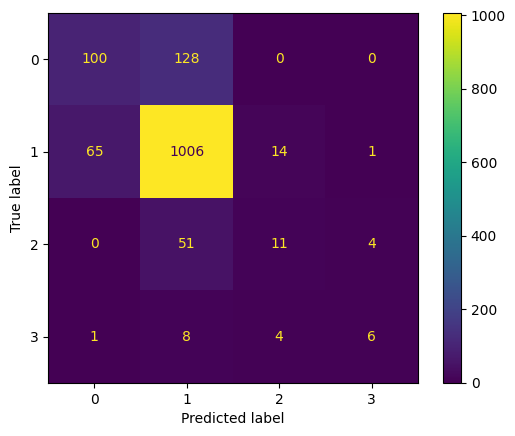

In [10]:
# Features (todas menos la columna objetivo)
X = df.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea entero)
y = df["estadoFitosanitario"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo XGBoost para clasificación
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_clf.fit(X_train, y_train)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()


Para solventar el desbalanceo de clases que tienen los datos, primero vamos a optar por submuestreo de las clases mayoritarias, es este caso `Regular` y `Bueno`

Accuracy: 0.7927090779127949

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57       228
           1       0.87      0.87      0.87      1086
           2       0.36      0.21      0.27        66
           3       0.62      0.42      0.50        19

    accuracy                           0.79      1399
   macro avg       0.59      0.53      0.55      1399
weighted avg       0.79      0.79      0.79      1399



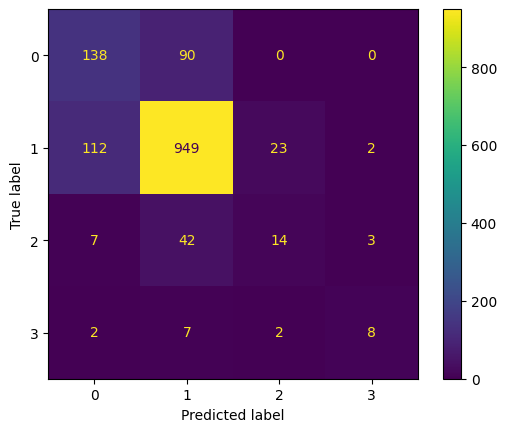

In [11]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)

# ---- Balancear SOLO el conjunto de entrenamiento ----
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# ---- Definir y entrenar modelo ----
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

xgb_clf.fit(X_train_res, y_train_res)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

Ahora analicemos un sobremuestreo de las clases minoritarias

Accuracy: 0.7090779127948534

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.42      0.51       228
           1       0.85      0.79      0.82      1086
           2       0.15      0.38      0.21        66
           3       0.14      0.53      0.22        19

    accuracy                           0.71      1399
   macro avg       0.45      0.53      0.44      1399
weighted avg       0.78      0.71      0.73      1399



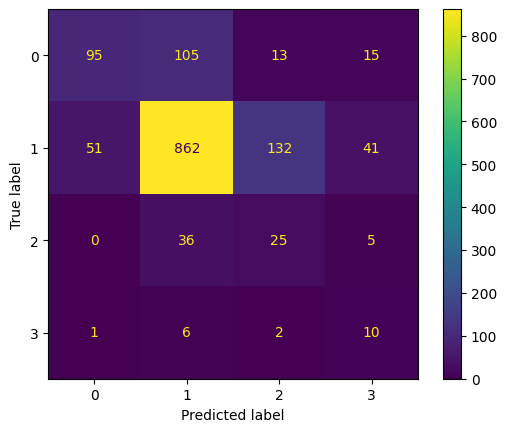

In [12]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

### Random Foresft - Classifier
---

Accuracy: 0.6847748391708363

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.61      0.52       228
           1       0.87      0.73      0.79      1086
           2       0.12      0.26      0.17        66
           3       0.19      0.47      0.27        19

    accuracy                           0.68      1399
   macro avg       0.41      0.52      0.44      1399
weighted avg       0.76      0.68      0.71      1399



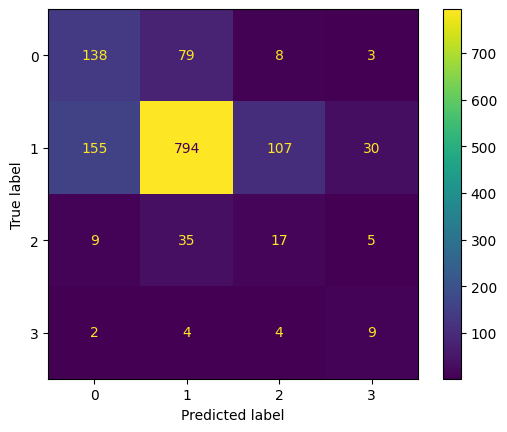

In [13]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.6497498213009293

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.64      0.50       228
           1       0.87      0.69      0.77      1086
           2       0.10      0.23      0.14        66
           3       0.07      0.16      0.10        19

    accuracy                           0.65      1399
   macro avg       0.36      0.43      0.38      1399
weighted avg       0.75      0.65      0.69      1399



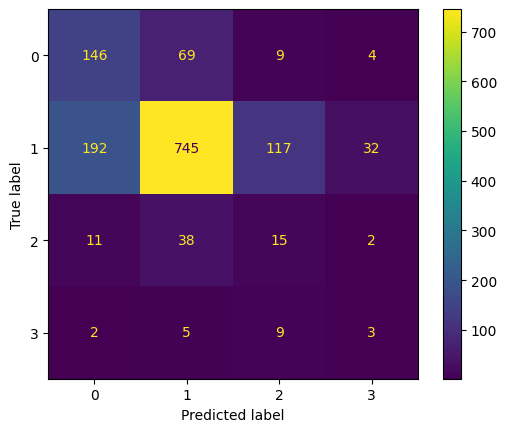

In [14]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

## Entrenamiento - 3 clases
----

### XGBoost - Classifier
---

In [15]:
df["estadoFitosanitario"] = df["estadoFitosanitario"].replace({2: 2, 3: 2})


In [16]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    5427
0    1142
2     423
Name: count, dtype: int64

Accuracy: 0.7398141529664046

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.44      0.52       228
           1       0.85      0.83      0.84      1086
           2       0.20      0.46      0.28        85

    accuracy                           0.74      1399
   macro avg       0.57      0.57      0.55      1399
weighted avg       0.78      0.74      0.75      1399



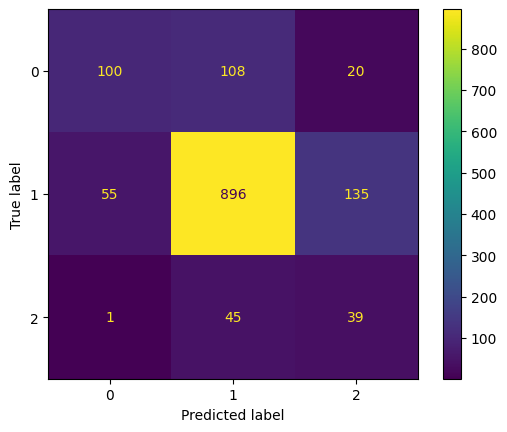

In [17]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()

### Random Forest - Classifier
---

Accuracy: 0.7269478198713367

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.61      0.54       228
           1       0.87      0.78      0.82      1086
           2       0.25      0.40      0.31        85

    accuracy                           0.73      1399
   macro avg       0.53      0.60      0.55      1399
weighted avg       0.77      0.73      0.74      1399



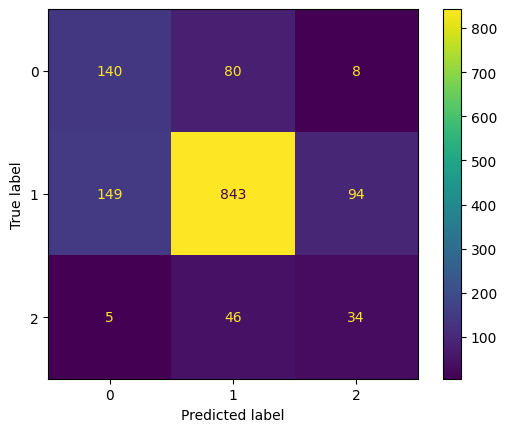

In [18]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)


# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.6847748391708363

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.68      0.52       228
           1       0.87      0.71      0.79      1086
           2       0.19      0.33      0.24        85

    accuracy                           0.68      1399
   macro avg       0.50      0.57      0.52      1399
weighted avg       0.76      0.68      0.71      1399



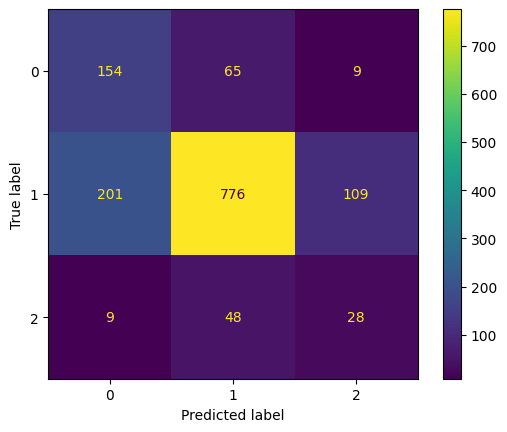

In [19]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]


# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

Ideas de Aumentación de datos:

- Autoencoder 
- GAN


## Rebalanceo de Clases - SMOTE
---

In [20]:
X = df.drop('estadoFitosanitario', axis=1)
y = df['estadoFitosanitario']

print("Distribución original:")
print(y.value_counts().sort_index())
print("-" * 50)

smoten = SMOTE(
    sampling_strategy='auto',  # balancea a la clase mayoritaria
    random_state=42,
    k_neighbors=5
)

X_res, y_res = smoten.fit_resample(X, y)

df_balanced = pd.DataFrame(X_res, columns=X.columns)
df_balanced['estadoFitosanitario'] = y_res

print("Distribución después de SMOTEN:")
print(df_balanced['estadoFitosanitario'].value_counts().sort_index())
print("-" * 50)
print(f"Total de filas: {len(df_balanced)}")

Distribución original:
estadoFitosanitario
0    1142
1    5427
2     423
Name: count, dtype: int64
--------------------------------------------------
Distribución después de SMOTEN:
estadoFitosanitario
0    5427
1    5427
2    5427
Name: count, dtype: int64
--------------------------------------------------
Total de filas: 16281


In [21]:
# Features y target
X = df_balanced.drop("estadoFitosanitario", axis=1)
y = df_balanced["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### XGBoost

Accuracy: 0.750076757752533

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76      1085
           1       0.66      0.72      0.69      1086
           2       0.85      0.77      0.81      1086

    accuracy                           0.75      3257
   macro avg       0.76      0.75      0.75      3257
weighted avg       0.76      0.75      0.75      3257



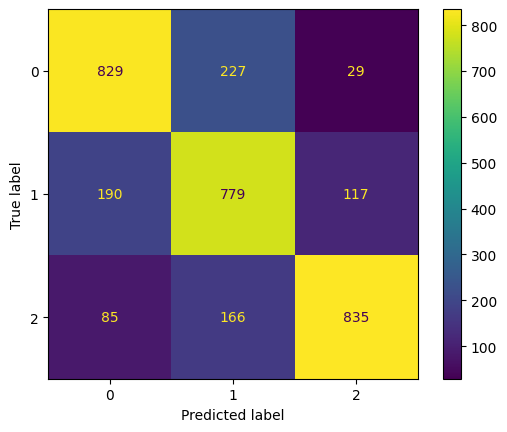

In [22]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    enable_categorical=True,   # <-- activa el manejo nativo
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()                                                              

### Random Forest

Accuracy: 0.776174393613755

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      1085
           1       0.73      0.70      0.72      1086
           2       0.85      0.82      0.83      1086

    accuracy                           0.78      3257
   macro avg       0.78      0.78      0.78      3257
weighted avg       0.78      0.78      0.78      3257



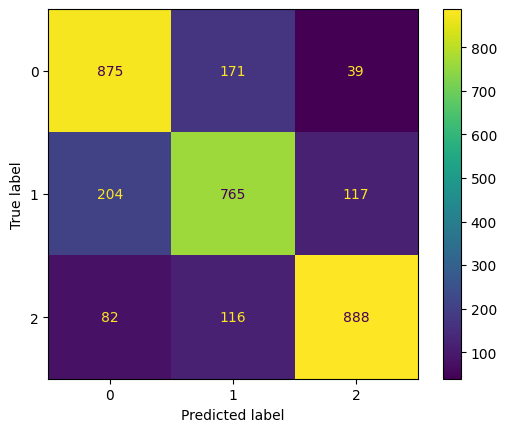

In [23]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier

Accuracy: 0.7623579981578139

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77      1085
           1       0.72      0.66      0.69      1086
           2       0.84      0.81      0.83      1086

    accuracy                           0.76      3257
   macro avg       0.76      0.76      0.76      3257
weighted avg       0.76      0.76      0.76      3257



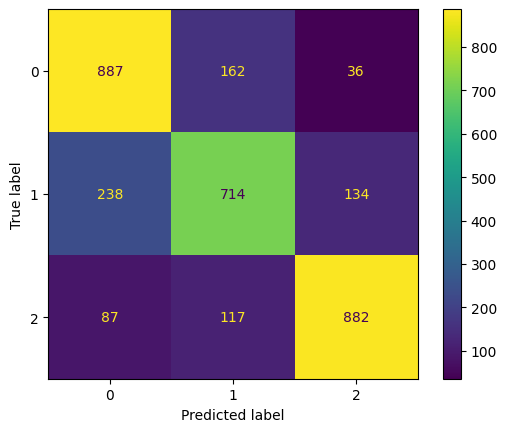

In [24]:
# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=None  # puedes ajustar para evitar overfitting
)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Gradient Boosting

Accuracy: 0.7279705250230273

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      1085
           1       0.64      0.71      0.67      1086
           2       0.83      0.73      0.78      1086

    accuracy                           0.73      3257
   macro avg       0.74      0.73      0.73      3257
weighted avg       0.74      0.73      0.73      3257



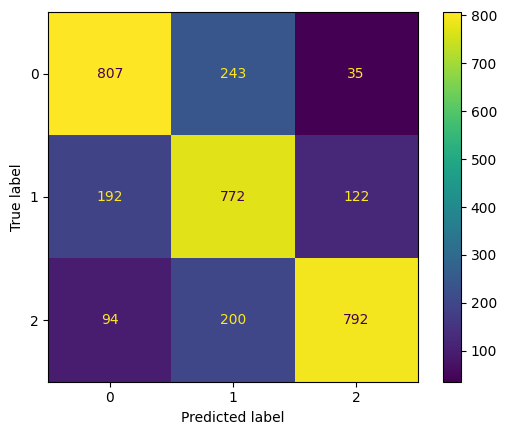

In [25]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()

## Rebalanceo de Clases - GAN
---

In [ ]:
df_input = df.copy()  # asume df ya definido con columna 'estadoFitosanitario'
label_col = 'estadoFitosanitario'
minority_label = 2  # cambiar por la etiqueta que quieras aumentar
n_epochs = 2000      # ajustar según poder de cómputo
batch_size = 64
latent_dim = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples_target = None  # si None, balancea hasta la clase mayoritaria

In [57]:
df_min = df_input[df_input[label_col] == minority_label].reset_index(drop=True)
X_min = df_min.drop(columns=[label_col]).select_dtypes(include=[np.number]).values

# escalado [ -1, 1 ] (coincide con tanh)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_min_scaled = scaler.fit_transform(X_min).astype(np.float32)

n_features = X_min_scaled.shape[1]

In [58]:
# decidir meta de muestras
if n_samples_target is None:
    # número mayoritario en dataset
    n_major = df_input[label_col].value_counts().max()
    n_to_generate = max(0, n_major - len(df_min))
else:
    n_to_generate = max(0, n_samples_target - len(df_min))

print(f"Ejemplos minoritarios reales: {len(df_min)}; generar: {n_to_generate}")

Ejemplos minoritarios reales: 423; generar: 5004


In [59]:
# --------------------------
# MODELOS (MLP simples)
# --------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
            nn.Tanh()   # porque escalamos a [-1,1]
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator(latent_dim, n_features).to(device)
D = Discriminator(n_features).to(device)

criterion = nn.BCELoss()
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

real_data = torch.tensor(X_min_scaled, dtype=torch.float32).to(device)

In [60]:
# --------------------------
# ENTRENAMIENTO
# --------------------------
n_real = real_data.size(0)
steps_per_epoch = max(1, n_real // batch_size)

for epoch in range(1, n_epochs + 1):
    for _ in range(steps_per_epoch):
        # 1) Entrenar D
        # sample real batch
        idx = np.random.randint(0, n_real, size=batch_size)
        real_batch = real_data[idx]

        # sample fake batch
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_batch = G(z)

        real_labels = torch.ones(batch_size, 1, device=device) * 0.9  # label smoothing
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2) Entrenar G
        z = torch.randn(batch_size, latent_dim, device=device)
        gen = G(z)
        pred = D(gen)
        loss_G = criterion(pred, real_labels)  # queremos que D clasifique como reales

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # Monitoreo
    # if epoch % 100 == 0 or epoch == 1:
    #     print(f"Epoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}")
    if epoch % 100 == 0 or epoch == 1:
        print(f"\rEpoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}", end="", flush=True)

Epoch 2000/2000 | loss_D: 0.8418 | loss_G: 1.7936

In [61]:
# --------------------------
# GENERAR NUEVAS MUESTRAS
# --------------------------
if n_to_generate > 0:
    G.eval()
    with torch.no_grad():
        z = torch.randn(n_to_generate, latent_dim, device=device)
        synthetic = G(z).cpu().numpy()
    synthetic_inv = scaler.inverse_transform(synthetic)
    df_synthetic = pd.DataFrame(synthetic_inv, columns=df_min.drop(columns=[label_col]).select_dtypes(include=[np.number]).columns)
    df_synthetic[label_col] = minority_label

    # Concatenar (si tenés columnas no numéricas habrá que reconstruirlas o usar CTGAN)
    df_balanced = pd.concat([df_input, df_synthetic], ignore_index=True)
else:
    df_balanced = df_input.copy()
    print("No se generaron muestras (ya estaba balanceado).")

In [62]:
df_input = df_balanced.copy()  # asume df ya definido con columna 'estadoFitosanitario'
label_col = 'estadoFitosanitario'
minority_label = 0  # cambiar por la etiqueta que quieras aumentar
n_epochs = 2000      # ajustar según poder de cómputo
batch_size = 64
latent_dim = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples_target = None  # si None, balancea hasta la clase mayoritaria

In [63]:
df_min = df_input[df_input[label_col] == minority_label].reset_index(drop=True)
X_min = df_min.drop(columns=[label_col]).select_dtypes(include=[np.number]).values

# escalado [ -1, 1 ] (coincide con tanh)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_min_scaled = scaler.fit_transform(X_min).astype(np.float32)

n_features = X_min_scaled.shape[1]

In [64]:
# decidir meta de muestras
if n_samples_target is None:
    # número mayoritario en dataset
    n_major = df_input[label_col].value_counts().max()
    n_to_generate = max(0, n_major - len(df_min))
else:
    n_to_generate = max(0, n_samples_target - len(df_min))

print(f"Ejemplos minoritarios reales: {len(df_min)}; generar: {n_to_generate}")

Ejemplos minoritarios reales: 1142; generar: 4285


In [65]:
# --------------------------
# MODELOS (MLP simples)
# --------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
            nn.Tanh()   # porque escalamos a [-1,1]
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator(latent_dim, n_features).to(device)
D = Discriminator(n_features).to(device)

criterion = nn.BCELoss()
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

real_data = torch.tensor(X_min_scaled, dtype=torch.float32).to(device)

In [66]:
# --------------------------
# ENTRENAMIENTO
# --------------------------
n_real = real_data.size(0)
steps_per_epoch = max(1, n_real // batch_size)

for epoch in range(1, n_epochs + 1):
    for _ in range(steps_per_epoch):
        # 1) Entrenar D
        # sample real batch
        idx = np.random.randint(0, n_real, size=batch_size)
        real_batch = real_data[idx]

        # sample fake batch
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_batch = G(z)

        real_labels = torch.ones(batch_size, 1, device=device) * 0.9  # label smoothing
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2) Entrenar G
        z = torch.randn(batch_size, latent_dim, device=device)
        gen = G(z)
        pred = D(gen)
        loss_G = criterion(pred, real_labels)  # queremos que D clasifique como reales

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # Monitoreo
    # if epoch % 100 == 0 or epoch == 1:
    #     print(f"Epoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}")
    if epoch % 100 == 0 or epoch == 1:
        print(f"\rEpoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}", end="", flush=True)

Epoch 2000/2000 | loss_D: 0.9300 | loss_G: 1.2123

In [67]:
# --------------------------
# GENERAR NUEVAS MUESTRAS
# --------------------------
if n_to_generate > 0:
    G.eval()
    with torch.no_grad():
        z = torch.randn(n_to_generate, latent_dim, device=device)
        synthetic = G(z).cpu().numpy()
    synthetic_inv = scaler.inverse_transform(synthetic)
    df_synthetic = pd.DataFrame(synthetic_inv, columns=df_min.drop(columns=[label_col]).select_dtypes(include=[np.number]).columns)
    df_synthetic[label_col] = minority_label

    # Concatenar (si tenés columnas no numéricas habrá que reconstruirlas o usar CTGAN)
    df_balanced = pd.concat([df_input, df_synthetic], ignore_index=True)
else:
    df_balanced = df_input.copy()
    print("No se generaron muestras (ya estaba balanceado).")

In [68]:
print("Distribución final:")
print(df_balanced[label_col].value_counts())

Distribución final:
estadoFitosanitario
0    5427
1    5427
2    5427
Name: count, dtype: int64


In [69]:
# Features y target
X = df_balanced.drop("estadoFitosanitario", axis=1)
y = df_balanced["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### XGBoost

Accuracy: 0.9146453791832975

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      1085
           1       0.85      0.91      0.88      1086
           2       0.99      0.94      0.96      1086

    accuracy                           0.91      3257
   macro avg       0.92      0.91      0.92      3257
weighted avg       0.92      0.91      0.92      3257



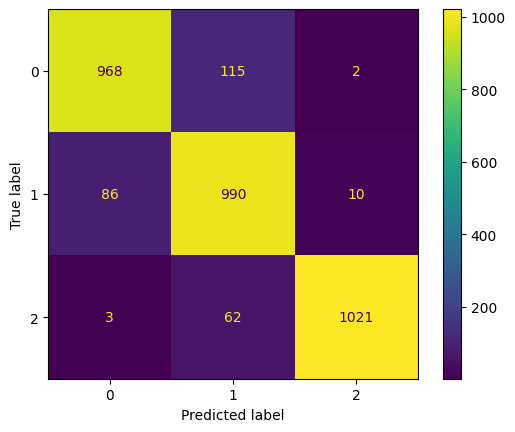

In [74]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    enable_categorical=True,   # <-- activa el manejo nativo
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()                                                              

### Random Forest

Accuracy: 0.9146453791832975

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1085
           1       0.85      0.91      0.88      1086
           2       0.99      0.94      0.96      1086

    accuracy                           0.91      3257
   macro avg       0.92      0.91      0.92      3257
weighted avg       0.92      0.91      0.92      3257



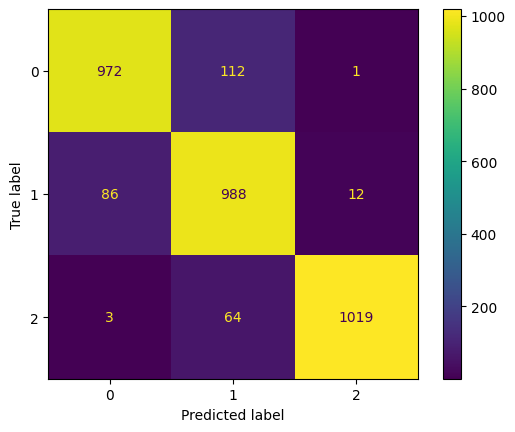

In [75]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier

Accuracy: 0.8959164875652441

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1085
           1       0.85      0.85      0.85      1086
           2       0.97      0.93      0.95      1086

    accuracy                           0.90      3257
   macro avg       0.90      0.90      0.90      3257
weighted avg       0.90      0.90      0.90      3257



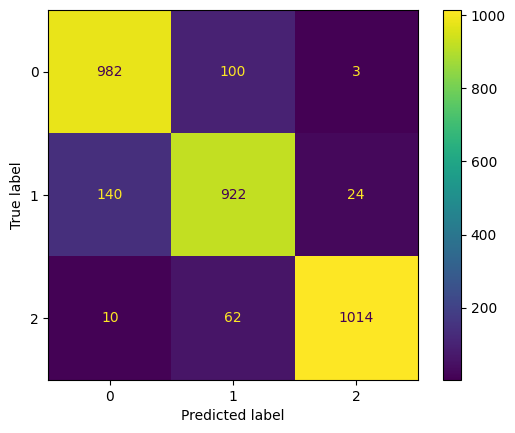

In [73]:
# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=None  # puedes ajustar para evitar overfitting
)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Gradient Boosting

Accuracy: 0.8891666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.45      0.52       228
           1       0.84      0.93      0.89      1086
           2       0.99      0.94      0.96      1086

    accuracy                           0.89      2400
   macro avg       0.81      0.77      0.79      2400
weighted avg       0.89      0.89      0.89      2400



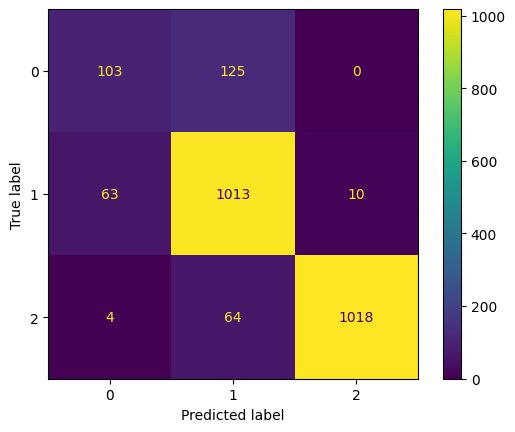

In [37]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()